Adapted by Carlos Toxtli http://www.carlostoxtli.com/#colab-style-3

Source: https://github.com/llSourcell/GANS-for-style-transfer/blob/master/demo2.ipynb

In [ ]:
!git clone https://github.com/ChunyuanLI/DiscoGAN.git
%cd DiscoGAN

Cloning into 'DiscoGAN'...
remote: Enumerating objects: 129, done.
remote: Total 129 (delta 0), reused 0 (delta 0), pack-reused 129
Receiving objects: 100% (129/129), 6.12 MiB | 21.83 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/content/DiscoGAN


# DiscoGAN

Learning to DISCOver Cross Domain Relations with GANs
https://www.youtube.com/watch?v=9reHvktowLY

![alt text](https://pbs.twimg.com/media/C7NDNRuXgAAfePz.jpg "Logo Title Text 1")

![alt text](http://www.aimechanic.com/wp-content/uploads/2017/03/PyTorch-DiscoGAN.png "Logo Title Text 1")


Cross-domain relations are natural to us humans.
- Suit jacket goes with dress shoes
- english-french translation

Can they be natural to machines?
It's a conditional image generation problem. 
i.e find a mapping function from one domain to the other 
i.e generate an image in one domain given another image in the other domain. 

most of today’s training approaches use explicitly paired
data, provided by human or another algorithm.

Let's do it with no labels :)
use cases
- games
- design with real time feedback


take 1 image and reconstruct in the style of another
- encoder-decoder? too naive (more like a camera filter) 
- 2 encoder-decoders? backwards compatible style transfer, but still naive
- 2 encoder-decorers in an adversarial context? Bingo. :) 


In [ ]:
#why GMM?
#why graph replace for discimrinator?
#slim repeat operation
#add 2 references


#bridging the python 2 and python 3 gap
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os # saving files
import numpy as np #matrix math

#visualizing data
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#machine learning
import tensorflow as tf

#gausian mixture model for generating data
from data_gmm import GMM_distribution, sample_GMM, plot_GMM
#analyzing data 
from data_utils import shuffle, iter_data

#progress bar
from tqdm import tqdm

#TF-Slim is a lightweight library for defining, training and evaluating models in TensorFlow. It enables defining complex networks quickly and concisely
slim = tf.contrib.slim

#Classes that represent batches of statistical distributions. 
#Each class is initialized with parameters that define the distributions
ds = tf.contrib.distributions

#Create a new graph which compute the targets from the replaced Tensors.

graph_replace = tf.contrib.graph_editor.graph_replace


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
#hyperparams
""" parameters """
n_epoch = 1000 #number of epcohs
batch_size  = 64
dataset_size = 512
input_dim = 2 #data and labels
latent_dim = 2 
eps_dim = 2


#discriminator
n_layer_disc = 2
n_hidden_disc = 256

#generator 
n_layer_gen = 2
n_hidden_gen= 256

#inference network (generator #2)
n_layer_inf = 2
n_hidden_inf= 256


In [ ]:
#save our results to the DiscoGAN folder
""" Create directory for results """
result_dir = 'results/DiscoGAN/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

![alt text](https://image.slidesharecdn.com/sampleproject-140814212447-phpapp02/95/speaker-recognition-using-gaussian-mixture-model-2-638.jpg?cb=1408051684
 "Logo Title Text 1")
 
A Gaussian mixture model is a probabilistic model  that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions  with unknown parameters.

![alt text](http://i.imgur.com/GJhzOUy.png "Logo Title Text 1")


- X = Dataset of n elements 
- alpha = Mixing weight of the kth component. 
- sigma = Gaussian probability density function
- mu =  Mean of the kth component.
- sigma2 = Variance of the kth component.


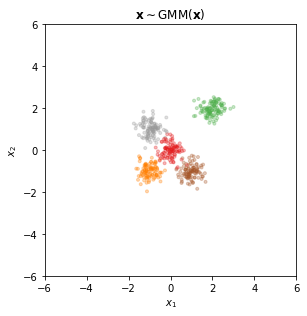

In [ ]:
#The demo is tested a toy dataset, 
#5-component GMM
#A Gaussian mixture model is a probabilistic model 
#that assumes all the data points are generated from 
#a mixture of a finite number of Gaussian distributions 
#with unknown parameters.

# create X dataset (first dataset)
#applies a function to all the items in an input_list
#lambda = anonymous functions (i.e. function that is not bound to a name)
#creates a numpy array of 5 components
means = map(lambda x:  np.array(x), [[0, 0],
                                     [2, 2],
                                     [-1, -1],
                                     [1, -1],
                                     [-1, 1]])

#convert to list to access methods
means = list(means)
#standard deviation
std = 0.1
#variances - eye Return an identiy matrix, 2-D array with 1s on the diagonal & 0s elsewhere.
variances = [np.eye(2) * std for _ in means]

# the probability distribution that would express one's beliefs about this 
#quantity before some evidence is taken into account
priors = [1.0/len(means) for _ in means]

#create gaussian mixture model 
gaussian_mixture = GMM_distribution(means=means,
                                               variances=variances,
                                               priors=priors)

#sample from the data using the GMM
dataset = sample_GMM(dataset_size, means, variances, priors, sources=('features', ))

#save the results
save_path = result_dir + 'X_gmm_data.pdf'
#plot the results
plot_GMM(dataset, save_path)

#store data and labels
X_np_data= dataset.data['samples']
X_labels = dataset.data['label']

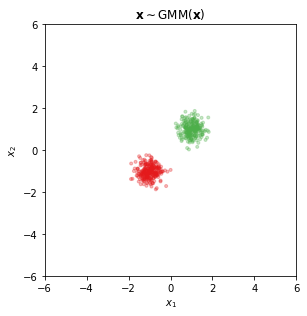

In [ ]:
# create Z dataset (second dataset)
#2-component GMM. 
means = map(lambda x:  np.array(x), [[-1, -1],[1, 1]])
means = list(means)
std = 0.1
variances = [np.eye(2) * std for _ in means]

priors = [1.0/len(means) for _ in means]

gaussian_mixture = GMM_distribution(means=means,
                                               variances=variances,
                                               priors=priors)
dataset = sample_GMM(dataset_size, means, variances, priors, sources=('features', ))
save_path = result_dir + 'Z_gmm_data.pdf'
plot_GMM(dataset, save_path)

Z_np_data= dataset.data['samples']
Z_labels = dataset.data['label']

In [ ]:
# samples of x and z
X_dataset = X_np_data
Z_dataset = Z_np_data

![alt text](https://pbs.twimg.com/media/C8QiTe2XcAATDfn.jpg "Logo Title Text 1")

![alt text](http://i.imgur.com/fkEbXXX.png "Logo Title Text 1")
. Illustration of our models on simplified one dimensional domains. (a) ideal mapping from domain A to domain B in which the
two domain A modes map to two different domain B modes, (b) GAN model failure case, (c) GAN with reconstruction model failure
case.



2 coupled models learn the mapping from one domain to another 
as well as  the reverse mapping for reconstruction. 

The two models are trained together simultaneously.

- 4 generators in total
- 2 discriminators

The two generators GAB’s and the two generators
GBA’s share parameters, and the generated images
xBA and xAB are each fed into separate discriminators LDA
and LDB , respectively.


In [ ]:
""" Networks """

#Each of the two coupled models learns the mapping from
#one domain to another, and also the reverse mapping to for
#reconstruction. The two models are trained together simultaneously.
#The two generators GAB’s and the two generators
#GBA’s share parameters, and the generated images
#xBA and xAB are each fed into separate discriminators LDA
#and LDB , respectively.



#2 generators
def generative_network(z, input_dim, n_layer, n_hidden, eps_dim):
    with tf.variable_scope("generative"):
        h = z
        #repeat allow us to repeatedly perform the same operation.
        #many fully connected layers
        h = slim.repeat(h, n_layer, slim.fully_connected, n_hidden, activation_fn=tf.nn.relu, reuse=tf.AUTO_REUSE)
        x = slim.fully_connected(h, input_dim, activation_fn=None, scope="p_x", reuse=tf.AUTO_REUSE)
    return x


def inference_network(x, latent_dim, n_layer, n_hidden, eps_dim):
    with tf.variable_scope("inference"):
        h = x
        h = slim.repeat(h, n_layer, slim.fully_connected, n_hidden, activation_fn=tf.nn.relu, reuse=tf.AUTO_REUSE)
        z = slim.fully_connected(h, latent_dim, activation_fn=None, scope="q_z", reuse=tf.AUTO_REUSE)
    return z


#2 discriminators
def data_network_x(x, n_layers=2, n_hidden=256, activation_fn=None):
    """Approximate x log data density."""
    h = tf.concat(x, 1)
    with tf.variable_scope('discriminator_x'):
        h = slim.repeat(h, n_layers, slim.fully_connected, n_hidden, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1]) #Removes dimensions of size 1 
    #from the shape of a tensor.



def data_network_z(z, n_layers=2, n_hidden=256, activation_fn=None):
    """Approximate z log data density."""
    h = tf.concat(z, 1)
    with tf.variable_scope('discriminator_z'):
        h = slim.repeat(h, n_layers, slim.fully_connected, n_hidden, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

In [ ]:
""" Construct model and training ops """
tf.reset_default_graph()

#data1 input
x = tf.placeholder(tf.float32, shape=(batch_size, input_dim))
#data 2 input
z = tf.placeholder(tf.float32, shape=(batch_size, latent_dim))

# 2 generators - encoders
p_x = generative_network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
q_z = inference_network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)

#The logit function is the inverse of the sigmoidal "logistic" function

#2 discriminators
decoder_logit_x = data_network_x(p_x, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
encoder_logit_x = graph_replace(decoder_logit_x, {p_x: x})

decoder_logit_z = data_network_z(q_z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
encoder_logit_z = graph_replace(decoder_logit_z, {q_z: z})

#Computes softplus: log(exp(features) + 1). activation
#for calculating loss
encoder_sigmoid_x = tf.nn.softplus(encoder_logit_x)
decoder_sigmoid_x = tf.nn.softplus(decoder_logit_x)
encoder_sigmoid_z = tf.nn.softplus(encoder_logit_z)
decoder_sigmoid_z = tf.nn.softplus(decoder_logit_z)

Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.


In [ ]:
#loss functions

#loss for both discriminators
decoder_loss = decoder_sigmoid_x + decoder_sigmoid_z
encoder_loss = encoder_sigmoid_x + encoder_sigmoid_z

#combined loss for discriminators
disc_loss = tf.reduce_mean(  encoder_loss ) - tf.reduce_mean( decoder_loss)

#2 more generators (decoders)
rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim )
rec_x = generative_network(q_z, input_dim , n_layer_gen, n_hidden_gen,  eps_dim )

#compute generator loss
#Sum of Squared Error loss
cost_z = tf.reduce_mean(tf.pow(rec_z - z, 2))
cost_x = tf.reduce_mean(tf.pow(rec_x - x, 2))
#we tie in discriminator loss into generators loss
adv_loss = tf.reduce_mean(  decoder_loss ) 
gen_loss = 1*adv_loss + 1.*cost_x  + 1.*cost_z

#collect vars with names that contain this
qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars_x = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_x")
dvars_z = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_z")

#use adam (gradient descent) to optimize
opt = tf.train.AdamOptimizer(1e-4, beta1=0.5)

#minimize generators loss
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)

#minimize discirimaintors loss
train_disc_op = opt.minimize(disc_loss, var_list=dvars_x + dvars_z)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
""" training """
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

FG = []
FD = []

#for each epoch (log the status bar)
for epoch in tqdm( range(n_epoch), total=n_epoch):
    #sample from both our datasets
    X_dataset, Z_dataset= shuffle(X_dataset, Z_dataset)

    #for each x and z in our data 
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        
        #minimize our loss functions
        for _ in range(1):
            f_d, _ = sess.run([disc_loss, train_disc_op], feed_dict={x: xmb, z:zmb})
        for _ in range(5):
            #3 components that make up generator loss
            f_g, _ = sess.run([[adv_loss, cost_x, cost_z], train_gen_op], feed_dict={x: xmb, z:zmb})

        FG.append(f_g)
        FD.append(f_d)


100%|██████████| 1000/1000 [03:35<00:00,  4.74it/s]


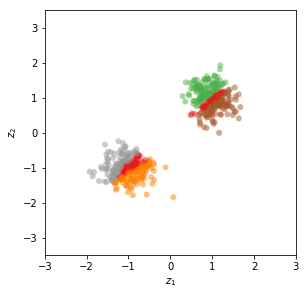

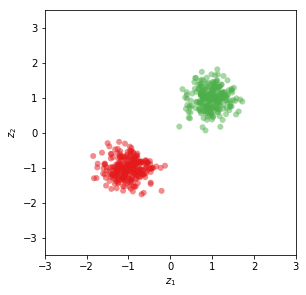

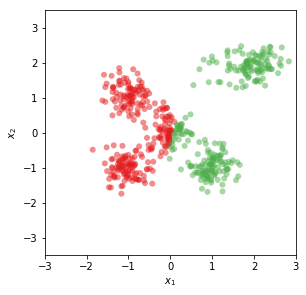

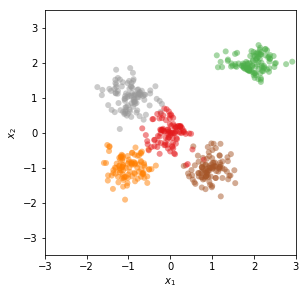

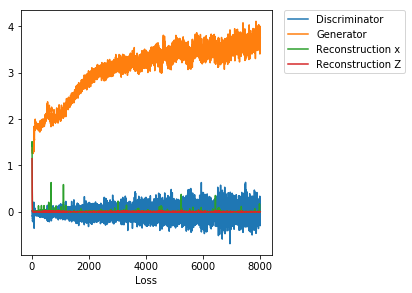

In [ ]:
""" plot the results """

n_viz = 1
imz = np.array([]); rmz = np.array([]); imx = np.array([]); rmx = np.array([]);
for _ in range(n_viz):
    for xmb, zmb in iter_data(X_np_data, Z_np_data, size=batch_size):
        temp_imz = sess.run(q_z, feed_dict={x: xmb, z:zmb})
        imz = np.vstack([imz, temp_imz]) if imz.size else temp_imz

        temp_rmz = sess.run(rec_z, feed_dict={x: xmb, z:zmb})
        rmz = np.vstack([rmz, temp_rmz]) if rmz.size else temp_rmz

        temp_imx = sess.run(p_x, feed_dict={x: xmb, z:zmb})
        imx = np.vstack([imx, temp_imx]) if imx.size else temp_imx

        temp_rmx = sess.run(rec_x, feed_dict={x: xmb, z:zmb})
        rmx = np.vstack([rmx, temp_rmx]) if rmx.size else temp_rmx

## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = np.tile(X_labels, (n_viz))
ax.scatter(imz[:, 0], imz[:, 1], c=cm.Set1(ll.astype(float)/input_dim/2.0),
        edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_mz.pdf', transparent=True, bbox_inches='tight')

##  reconstruced z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = np.tile(Z_labels, (n_viz))
ax.scatter(rmz[:, 0], rmz[:, 1], c=cm.Set1(ll.astype(float)/input_dim/2.0),
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'reconstruct_mz.pdf', transparent=True, bbox_inches='tight')

## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = np.tile(Z_labels, (n_viz))
ax.scatter(imx[:, 0], imx[:, 1], c=cm.Set1(ll.astype(float)/input_dim/2.0),
        edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_mx.pdf', transparent=True, bbox_inches='tight')

##  reconstruced x
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = np.tile(X_labels, (n_viz))
ax.scatter(rmx[:, 0], rmx[:, 1], c=cm.Set1(ll.astype(float)/input_dim/2.0),
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
plt.savefig(result_dir + 'reconstruct_mx.pdf', transparent=True, bbox_inches='tight')

## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
plt.savefig(result_dir + 'learning_curves.pdf', bbox_inches='tight')
